# Dataset
This data is downloaded from UCI repository, link at...
This database contains 279 attributes, 206 of which are linear valued and the rest are nominal.

Concerning the study of H. Altay Guvenir: "The aim is to distinguish between the presence and absence of cardiac arrhythmia and to classify it in one of the 16 groups. Class 01 refers to 'normal' ECG classes 02 to 15 refers to different classes of arrhythmia and class 16 refers to the rest of unclassified ones. For the time being, there exists a computer program that makes such a classification. However there are differences between the cardiolog's and the programs classification. Taking the cardiolog's as a gold standard we aim to minimise this difference by means of machine learning tools." 

# This notebook: #
A simple artificial neural network (ANN) and a convoluational neural network (CNN) are constructed to classify whether patients are healthy, have some type of arrhythmia, or some type of unclassifies arrhythmia. Primarily, the goal is to see how rebalancing the dataset impacts the efficiency of the model, as well as to compare the performances of the two different models.


In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
import matplotlib.pyplot as plt



In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [189]:
file = "/content/drive/MyDrive/arrhythmia.gsheet"

df = pd.read_csv('/content/drive/MyDrive/data_arrhythmia.csv',sep=';')
df.head(15)

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,T,P,QRST,J,heart_rate,q_wave,r_wave,s_wave,R'_wave,S'_wave,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AR,AS,AT,AU,...,JO,JP,JR,JS,JT,JU,JV,JY,JZ,KA,KB,KC,KD,KE,KF,KG,KH,KI,KJ,KK,KL,KM,KN,KO,KP,KR,KS,KT,KU,KV,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,?,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,?,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,?,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13,61,3,?,?,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7
5,13,0,169,51,100,167,321,174,91,107,66,52,88,?,84,0,36,48,0,0,20,0,0,0,0,0,0,20,44,36,0,0,44,0,0,0,0,0,0,24,...,-0.8,19.8,-48.4,0.0,0.0,1.6,8.7,-114.5,-72.8,2.0,0.0,31.0,-25.7,0.0,0.0,0.8,5.9,29.2,85.8,0.6,0.0,19.5,-11.4,0.0,0,0.8,3.3,20.1,49.1,0.0,-0.6,12.2,-2.8,0.0,0,0.9,2.2,13.5,31.1,14
6,40,1,160,52,77,129,377,133,77,77,49,75,65,?,70,0,44,0,0,0,24,0,0,0,0,0,0,0,40,32,0,0,24,0,0,0,0,0,0,0,...,0.0,3.7,-11.0,0.0,0.0,-0.5,4.1,-19.8,21.2,0.1,0.0,7.7,-6.4,0.0,0.0,0.4,1.9,1.4,15.4,0.0,0.0,7.4,-2.5,0.0,0,0.4,1.3,9.3,18.9,-0.4,0.0,6.5,0.0,0.0,0,0.4,1.0,14.3,20.5,1
7,49,1,162,54,78,0,376,157,70,67,7,8,51,?,67,0,44,36,0,0,24,0,0,0,0,0,0,0,52,32,0,0,28,0,0,0,0,0,0,0,...,0.0,2.1,-9.0,0.0,0.0,0.6,3.8,-16.1,21.1,0.1,0.0,6.6,-4.1,0.0,0.0,0.3,1.4,4.7,14.2,-0.2,0.0,8.5,-2.7,0.0,0,0.1,0.8,14.5,20.9,-0.3,0.0,8.2,-1.9,0.0,0,0.1,0.5,15.8,19.8,1
8,44,0,168,56,84,118,354,160,63,61,69,78,66,84,64,0,40,0,0,0,20,0,0,0,0,0,0,0,44,12,0,0,28,0,0,0,0,0,0,0,...,0.0,2.4,-10.3,0.0,0.0,0.3,6.8,-19.3,43.2,0.8,0.0,7.9,-7.3,0.0,0.0,0.9,6.5,5.7,62.9,0.1,0.0,9.3,-3.8,0.0,0,0.8,3.8,15.1,48.5,0.1,0.0,7.0,-1.3,0.0,0,0.6,2.1,12.5,30.9,1
9,50,1,167,67,89,130,383,156,73,85,34,70,71,?,63,0,44,40,0,0,28,0,0,0,0,0,0,0,56,24,0,0,32,0,0,0,0,0,0,0,...,0.0,4.3,-7.3,0.0,0.0,1.1,4.0,-8.9,27.9,-0.5,0.0,7.0,-3.2,0.0,0.0,1.1,1.3,13.2,22.3,-0.5,0.0,10.9,-2.5,0.0,0,1.0,1.0,23.8,29.6,-0.5,-0.6,10.8,-1.7,0.0,0,0.8,0.9,20.1,25.1,10


Checking for null values:

In [190]:
count=0
for i in range(0,452):
    for j in range(0,280):
        if (df.iloc[i,j]=='?'):
            count =count+1
print(count)
df = df.replace('?', np.NaN)

408


In [191]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})


In [192]:
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df.head(10)

,column_name,percent_missing
J,J,83.185841
P,P,4.867257
T,T,1.769912
QRST,QRST,0.221239
heart_rate,heart_rate,0.221239
HM,HM,0.000000
HL,HL,0.000000
HK,HK,0.000000
HJ,HJ,0.000000
HI,HI,0.000000


There are totally 5 columns that contain null values. 83% of Column 'J' consists of null values so will will drop this column. For the other columns, ie. 'P', 'T', 'QRST', and 'heart_rate' we will impute the values.

In [193]:
df.drop('J',axis=1,inplace=True)

In [194]:
null_value_cols=['P','T','QRST','heart_rate']
df[null_value_cols] = df[null_value_cols].apply(pd.to_numeric, errors='coerce')
df[null_value_cols]=df[null_value_cols].fillna(df[null_value_cols].mean())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


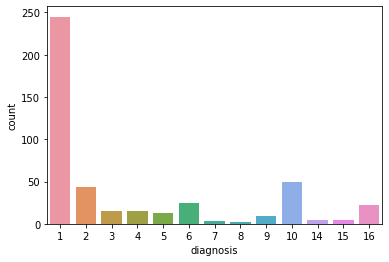

In [195]:
sns.countplot(df['diagnosis'])

There are 16 classes in a dataset wiht only 456 entries. There is not enough data to accurately classify each class indiviually so we will group the classes into "healthy", "has arrthymia", and " has unclassifed arrhythmia".

In [196]:
conditions = [
    (df['diagnosis'] == 1),
    (df['diagnosis'] > 1) & (df['diagnosis'] <16),
    (df['diagnosis'] == 16)]
    
values=['0','1','2']
df['diagnosis'] = np.select(conditions, values)
df['diagnosis'] = df['diagnosis'].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


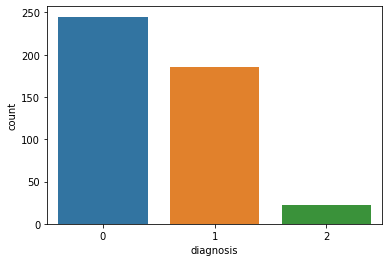

In [197]:
sns.countplot(df['diagnosis'])

# Model Prep

In [198]:
y=df[['diagnosis']]
df.drop('diagnosis', axis=1, inplace=True)
X=df

In [199]:
from sklearn.model_selection import train_test_split

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y ,test_size=0.2, random_state=42 )

# Model Building

### Model 1: 1 layer Artifical Neural Network

In [201]:
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, confusion_matrix
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score, KFold, StratifiedKFold


Model Acrhitecture:

In [202]:
def baseline_model(input_dim=278):
	model = Sequential()
	model.add(Dense(20, input_dim=input_dim, activation='relu', kernel_initializer='he_uniform'))
	# Units in output layer should be equal to number of categories
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
	return model

We will be performing fitting and cross validation on only our training set to prevent data leakage. The model will be tested on the unseen test data later to determine its performance.

In [203]:
def eval(X_train,y_train):  
  # Prepping X and y formats so that it can be processed by a neural network
  X_train=X_train.values
  y_train = np_utils.to_categorical(y_train)
  estimator = KerasClassifier(build_fn = baseline_model, epochs = 100, batch_size = 10, verbose = 0)
  skf = KFold(n_splits=5, random_state=None)
  results = cross_val_score(estimator, X_train, y_train,scoring='roc_auc', cv = skf)
  print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
  model=baseline_model()
  model.save("ANN_model")

In [205]:
eval(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """


Result: 65.40% (2.59%)
INFO:tensorflow:Assets written to: ANN_model/assets


### Class Rebalancing
As we saw earlier, the the number of instances for each class are highly unequal, espescially with the third class, "Unclassified Arrhythmia". We will try to resample our data to create a balanced dataset to improve the model.

In [206]:
df= pd.concat([X, y], axis=1)

In [207]:
# class rebalancing
from sklearn.utils import resample
from sklearn.utils import shuffle

df_0=df[df['diagnosis']==0]
df_1=df[df['diagnosis']==1]
df_2=df[df['diagnosis']==2]

df_0_upsample=resample(df_0,replace=True,n_samples=500,random_state=122)
df_1_upsample=resample(df_1,replace=True,n_samples=500,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=500,random_state=124)

df_resampled=pd.concat([df_0_upsample,df_1_upsample,df_2_upsample])

# Shuffle data
df_resampled = shuffle(df_resampled, random_state=12)

# Split thr target column
y_rebalance = df_resampled[['diagnosis']]
df_resampled = df_resampled.drop(['diagnosis'],axis=1)
X_rebalance=df_resampled
print(X_rebalance.shape)
print(y_rebalance.shape)


(1500, 278)
(1500, 1)


In [208]:
# New train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rebalance,y_rebalance, stratify=y_rebalance ,test_size=0.2, random_state=42 )

In [209]:
y_train.value_counts()

diagnosis
2            400
1            400
0            400
dtype: int64

In [210]:
eval(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """


Result: 98.07% (0.97%)
INFO:tensorflow:Assets written to: ANN_model/assets


The model has now significantly improved after resampling. Let's now test the model on unseen data 

In [211]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()

In [219]:
from numpy import argmax
from sklearn.metrics import roc_auc_score

def performance(X_train,X_test,y_train,y_test,model):
  X_test=X_test.values
  y_test = np_utils.to_categorical(y_test)
  X_train=X_train.values
  y_train = np_utils.to_categorical(y_train)
  model.fit(X_train, y_train)
  yhat = model.predict(X_test)
  
  ypred = argmax(yhat,axis=1)
  ypred= np_utils.to_categorical(ypred)  
  
  score = roc_auc_score(y_test, ypred, average='macro')
  draw_confusion_matrix(y_test.argmax(axis=1), ypred.argmax(axis=1))
  print('roc_auc_score score:',score)


38/38 [==============================] - 1s 2ms/step - loss: 10.1282 - accuracy: 0.3450


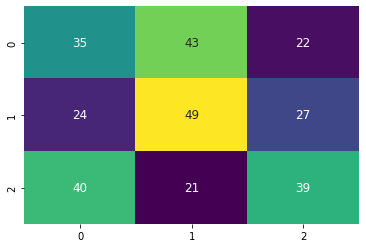

roc_auc_score score: 0.5575


In [213]:
ANN_model = keras.models.load_model("ANN_model")
performance(X_train,X_test,y_train,y_test,ANN_model)

The model has a low score in the test data. This may indicate overfitting. Parameter tuning and model improvement will be needed to determine the exact cause.

### Model 2: 1D CNN

In [214]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

Defining the model:

In [215]:
def network(in_sh=(278, 1)):
    im_shape=in_sh
    inputs_cnn=tf.keras.Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
   
    flatten=Flatten()(pool1)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end1 = Dropout(0.5)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    dense_end2 = Dropout(0.5)(dense_end2)
    
    main_output = Dense(3, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])    
    return model

Fitting and evaluating:

In [216]:

def fit_evauluate(X_train,y_train):
  callbacks = [EarlyStopping(monitor='val_loss', mode='min',patience=8),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)] 
  skf = StratifiedKFold(n_splits=5, shuffle=True)
  model=network(in_sh=(278, 1))
  for train_index, val_index in skf.split(X_train,y_train):
    X1_train, X1_val, y1_train, y1_val= X_train.iloc[train_index], X_train.iloc[val_index], y_train.iloc[train_index], y_train.iloc[val_index]
    y1_train= tf.keras.utils.to_categorical(y1_train,3)
    y1_val=tf.keras.utils.to_categorical(y1_val,3)    
    model_history=[]
    results = model.fit(X1_train, y1_train, epochs=10, batch_size=32, callbacks=callbacks,verbose=1,validation_split=0.1)
    model_history.append(results)
    print("Val Score: ", model.evaluate(X1_val, y1_val))


In [217]:
fit_evauluate(X_train,y_train)

Epoch 1/10
27/27 [==============================] - 1s 31ms/step - loss: 6.1756 - accuracy: 0.3322 - val_loss: 1.0985 - val_accuracy: 0.3646
Epoch 2/10
27/27 [==============================] - 0s 18ms/step - loss: 1.0988 - accuracy: 0.3299 - val_loss: 1.0988 - val_accuracy: 0.3646
Epoch 3/10
27/27 [==============================] - 1s 19ms/step - loss: 1.0987 - accuracy: 0.3356 - val_loss: 1.0988 - val_accuracy: 0.3646
Epoch 4/10
27/27 [==============================] - 0s 19ms/step - loss: 1.0987 - accuracy: 0.3426 - val_loss: 1.0989 - val_accuracy: 0.3646
Epoch 5/10
27/27 [==============================] - 1s 19ms/step - loss: 1.0988 - accuracy: 0.3206 - val_loss: 1.0988 - val_accuracy: 0.2812
Epoch 6/10
27/27 [==============================] - 0s 18ms/step - loss: 1.0984 - accuracy: 0.3356 - val_loss: 1.0993 - val_accuracy: 0.2812
Epoch 7/10
27/27 [==============================] - 1s 19ms/step - loss: 1.0988 - accuracy: 0.3368 - val_loss: 1.0991 - val_accuracy: 0.2812
Epoch 8/10
27

Testing on unseen data:

38/38 [==============================] - 1s 19ms/step - loss: 1.0987 - accuracy: 0.3283


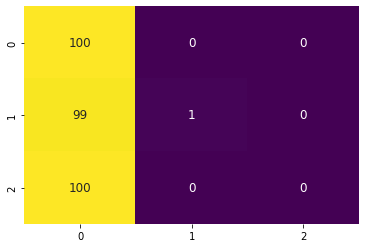

roc_auc_score score: 0.5037499999999999


In [221]:
CNN_model = keras.models.load_model('best_model.h5')
performance(X_train,X_test,y_train,y_test, CNN_model)

This model is only marginally better than the ANN model. Further improvements such as adding layers, tuning hyperparameters, or more pre processing can be done to increase accuracy